In [ ]:
!pip install -q transformers datasets evaluate sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import evaluate
from torch.optim import AdamW
from sklearn.model_selection import train_test_split


In [ ]:
CLEAN_PATH = "/content/drive/MyDrive/SENTIEMENT_MODEL/clean_sentiment_dataset.csv"
df = pd.read_csv(CLEAN_PATH)

df = df[df.label.isin(["positive","negative","notr"])]
df.label.value_counts()


,count
label,
positive,305037
notr,215216
negative,101287


In [ ]:
min_count = df.label.value_counts().min()
balanced = df.groupby("label").apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
balanced.label.value_counts()


/tmp/ipython-input-4240356816.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced = df.groupby("label").apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


,count
label,
negative,101287
notr,101287
positive,101287


In [ ]:

train_df, test_df = train_test_split(
    balanced,
    test_size=0.1,
    stratify=balanced["label"],
    random_state=42
)

train_df['label'].value_counts(), test_df['label'].value_counts()


(label
 notr        91158
 negative    91158
 positive    91158
 Name: count, dtype: int64,
 label
 positive    10129
 negative    10129
 notr        10129
 Name: count, dtype: int64)

In [ ]:
MODEL_NAME = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 96

def encode_texts(texts):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors="pt"
    )


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [ ]:
label_mapping = {"negative":0,"notr":1,"positive":2}

class SentimentDataset(Dataset):
    def __init__(self, df):
        self.encodings = encode_texts(df["text"])
        self.labels = torch.tensor(df["label"].map(label_mapping).values)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = SentimentDataset(train_df)
test_dataset = SentimentDataset(test_df)


In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

y_train = train_df["label"].map(label_mapping).values
classes = np.array([0,1,2])
cw = compute_class_weight("balanced", classes=classes, y=y_train)
class_weights = torch.tensor(cw, dtype=torch.float).to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

scaler = torch.cuda.amp.GradScaler()


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3210973679.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # FP16


In [ ]:
f1_metric = evaluate.load("f1")
acc_metric = evaluate.load("accuracy")


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=1)
            preds.extend(batch_preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    acc = acc_metric.compute(predictions=preds, references=true_labels)['accuracy']
    f1_macro = f1_metric.compute(predictions=preds, references=true_labels, average="macro")['f1']

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Test Acc: {acc:.4f} | Test F1 Macro: {f1_macro:.4f}")


/tmp/ipython-input-1224652414.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5 | Train Loss: 0.2534 | Test Acc: 0.9175 | Test F1 Macro: 0.9175


/tmp/ipython-input-1224652414.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/5 | Train Loss: 0.1857 | Test Acc: 0.9194 | Test F1 Macro: 0.9194


/tmp/ipython-input-1224652414.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/5 | Train Loss: 0.1448 | Test Acc: 0.9160 | Test F1 Macro: 0.9159


/tmp/ipython-input-1224652414.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/5 | Train Loss: 0.1133 | Test Acc: 0.9120 | Test F1 Macro: 0.9122


/tmp/ipython-input-1224652414.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/5 | Train Loss: 0.0904 | Test Acc: 0.9155 | Test F1 Macro: 0.9154


Test Accuracy: 0.9155
Test Macro F1: 0.9154


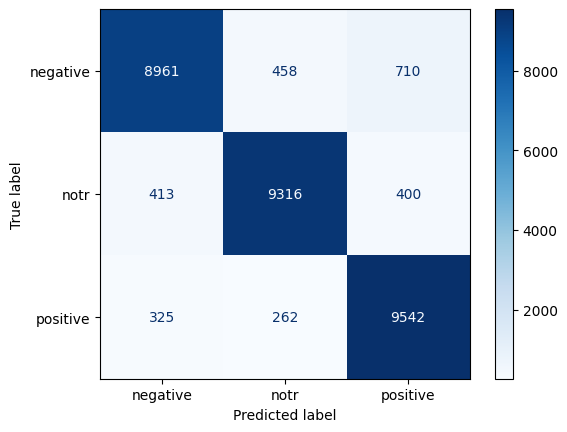

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

model.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=1)

        preds.extend(batch_preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

acc = acc_metric.compute(predictions=preds, references=true_labels)['accuracy']
f1_macro = f1_metric.compute(predictions=preds, references=true_labels, average="macro")['f1']

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Macro F1: {f1_macro:.4f}")


cm = confusion_matrix(true_labels, preds, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative","notr","positive"])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(inputs, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_true, y_pred, digits=4)
print("\nClassification Report:")
print(report)


Confusion Matrix:
[[8961  458  710]
 [ 413 9316  400]
 [ 325  262 9542]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9239    0.8847    0.9039     10129
           1     0.9283    0.9197    0.9240     10129
           2     0.8958    0.9420    0.9183     10129

    accuracy                         0.9155     30387
   macro avg     0.9160    0.9155    0.9154     30387
weighted avg     0.9160    0.9155    0.9154     30387



In [ ]:
SAVE_PATH = "/content/drive/MyDrive/SENTIEMENT_MODEL/bert_turk_sentiment_model"
model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)
print("Model kaydedildi:", SAVE_PATH)


Model kaydedildi: /content/drive/MyDrive/SENTIEMENT_MODEL/bert_turk_sentiment_model
